Further clean some columns and focus on
consumption-for-eg-btu >>>> electricity generation | ash-content | heat-content

In [34]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sqlalchemy import create_engine

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [35]:
db = 'eia_electric.sqlite'

In [36]:
engine = create_engine(f'sqlite:///{db}')
conn = engine.connect()

In [37]:
data = pd.read_sql('SELECT * FROM epo', conn, parse_dates = ['period'])
data.head()

,period,energySource,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
0,2008-01-01,fossil fuels,308.89,3734358.85,27878.91,594559.14,1025.72,4477.05,692.55,2854188.91,974.95,4011940.29,26408984.47,2367212.11,81.48,4328918.00,28904.63
1,2008-01-01,others,0.00,2666.20,2263.20,12391.55,7.95,0.00,0.00,214662.90,0.00,0.00,0.00,0.00,0.00,15057.75,2271.15
2,2008-01-01,renewables,254.19,51894.93,1381.14,4114.64,453.03,591.66,101.83,126059.98,101.13,4074.26,44771.59,7392.34,8.36,56009.57,1834.17
3,2008-02-01,fossil fuels,169.75,1476772.66,10823.13,321531.26,499.01,2371.16,374.65,1092655.81,617.48,1660658.05,10715695.93,1002393.72,64.86,1798303.92,11322.14
4,2008-02-01,others,0.00,913.06,13.82,8851.58,3.47,0.00,0.00,1004.15,0.00,0.00,0.00,0.00,0.00,9764.64,17.29


In [38]:
engine.dispose()

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   period                  539 non-null    datetime64[ns]
 1   energySource            539 non-null    object        
 2   ash-content             539 non-null    float64       
 3   consumption-for-eg      539 non-null    float64       
 4   consumption-for-eg-btu  539 non-null    float64       
 5   consumption-uto         539 non-null    float64       
 6   consumption-uto-btu     539 non-null    float64       
 7   cost                    539 non-null    float64       
 8   cost-per-btu            539 non-null    float64       
 9   generation              539 non-null    float64       
 10  heat-content            539 non-null    float64       
 11  receipts                539 non-null    float64       
 12  receipts-btu            539 non-null    float64   

In [40]:
data.describe()

,period,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
count,539,539.000000,5.390000e+02,539.000000,539.000000,539.000000,539.000000,539.000000,5.390000e+02,539.000000,5.390000e+02,5.390000e+02,5.390000e+02,539.000000,5.390000e+02,539.000000
mean,2015-06-13 00:58:46.530612224,91.986030,8.858754e+05,3967.218998,113223.819685,231.694082,600.468905,82.841336,4.280473e+05,246.539258,8.558034e+05,3.106432e+06,2.438369e+05,19.361354,9.992302e+05,4198.913135
min,2008-01-01 00:00:00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,2011-09-16 00:00:00,0.000000,2.488380e+03,948.415000,822.205000,4.995000,0.000000,0.000000,9.362144e+04,52.615000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,5.212675e+03,1023.150000
50%,2015-06-01 00:00:00,78.410000,9.381069e+04,1790.790000,15942.150000,179.080000,41.500000,3.330000,1.860718e+05,113.550000,1.051180e+03,1.224471e+04,1.372160e+03,3.740000,1.094533e+05,1970.550000
75%,2019-03-01 00:00:00,155.365000,1.267921e+06,4721.825000,149647.160000,396.885000,794.165000,115.065000,5.558912e+05,378.995000,1.267895e+06,4.647997e+06,3.149079e+05,33.735000,1.534678e+06,5104.835000
max,2022-12-01 00:00:00,468.930000,8.481988e+06,28266.020000,914975.860000,1110.850000,6373.860000,1002.720000,2.962540e+06,1148.580000,8.274031e+06,3.082787e+07,2.670282e+06,139.610000,9.162980e+06,29291.750000
std,NaN,94.445102,1.539172e+06,5048.938257,187679.520475,242.430036,1039.294813,145.828223,5.421836e+05,280.602127,1.561441e+06,5.573904e+06,4.743394e+05,28.578948,1.700005e+06,5228.480098


In [41]:
# Create DF of each energySource
# ff_df = data.loc[data['energySource'] == 'fossil fuels'].drop(columns = ['energySource']).reset_index(drop = True)
# re_df = data.loc[data['energySource'] == 'renewables'].drop(columns = ['energySource']).reset_index(drop = True)
# oth_df = data.loc[data['energySource'] == 'others'].drop(columns = ['energySource']).reset_index(drop = True)
ff_df = data.loc[data['energySource'] == 'fossil fuels'].drop(columns = ['energySource']).set_index('period')
re_df = data.loc[data['energySource'] == 'renewables'].drop(columns = ['energySource']).set_index('period')
oth_df = data.loc[data['energySource'] == 'others'].drop(columns = ['energySource']).set_index('period')

In [42]:
# View the DF
display(ff_df.head())
display(re_df.head())
display(oth_df.head())

,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
period,,,,,,,,,,,,,,,
2008-01-01,308.89,3734358.85,27878.91,594559.14,1025.72,4477.05,692.55,2854188.91,974.95,4011940.29,26408984.47,2367212.11,81.48,4328918.00,28904.63
2008-02-01,169.75,1476772.66,10823.13,321531.26,499.01,2371.16,374.65,1092655.81,617.48,1660658.05,10715695.93,1002393.72,64.86,1798303.92,11322.14
2008-03-01,186.00,2082011.42,18790.52,391763.24,517.57,2835.72,430.28,1896707.59,636.02,2399500.27,19884252.94,1688695.23,57.80,2473774.66,19308.09
2008-04-01,141.35,1203472.47,3568.69,292456.65,365.29,3000.42,467.37,389797.38,597.83,1418512.17,4269570.66,383229.39,57.73,1495929.12,3933.97
2008-05-01,292.46,3564108.14,20102.26,346582.24,613.08,4866.52,811.72,2047455.12,859.70,3941582.44,22080016.66,1857521.77,81.20,3910690.38,20715.35


,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
period,,,,,,,,,,,,,,,
2008-01-01,254.19,51894.93,1381.14,4114.64,453.03,591.66,101.83,126059.98,101.13,4074.26,44771.59,7392.34,8.36,56009.57,1834.17
2008-02-01,84.50,56674.93,984.17,11392.97,286.58,79.05,10.15,92283.99,26.48,467.08,5661.45,0.31,2.22,68067.89,1270.75
2008-03-01,121.44,86340.29,1096.70,2532.69,275.74,301.47,48.14,97623.18,57.18,1673.73,19221.36,2269.99,7.06,88872.98,1372.43
2008-04-01,183.17,65583.37,955.16,3220.26,111.66,328.71,53.69,88211.84,63.21,3321.70,38998.03,3663.94,8.07,68803.63,1066.82
2008-05-01,192.42,114449.16,2110.28,10828.85,514.37,434.22,69.25,204628.12,82.69,2072.81,22865.65,2210.53,7.72,125278.01,2624.66


,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
period,,,,,,,,,,,,,,,
2008-01-01,0.0,2666.20,2263.20,12391.55,7.95,0.0,0.0,214662.90,0.0,0.0,0.0,0.0,0.0,15057.75,2271.15
2008-02-01,0.0,913.06,13.82,8851.58,3.47,0.0,0.0,1004.15,0.0,0.0,0.0,0.0,0.0,9764.64,17.29
2008-03-01,0.0,417.94,364.76,18515.54,4.11,0.0,0.0,34789.20,0.0,0.0,0.0,0.0,0.0,18933.48,368.87
2008-04-01,0.0,88.84,1476.02,136.23,1.46,0.0,0.0,140679.82,0.0,0.0,0.0,0.0,0.0,225.07,1477.48
2008-05-01,0.0,1493.50,2067.83,8539.97,3.84,0.0,0.0,196224.27,0.0,0.0,0.0,0.0,0.0,10033.47,2071.67


In [43]:
# Check dType for one to verify the data types are correct
ff_df.dtypes

ash-content               float64
consumption-for-eg        float64
consumption-for-eg-btu    float64
consumption-uto           float64
consumption-uto-btu       float64
cost                      float64
cost-per-btu              float64
generation                float64
heat-content              float64
receipts                  float64
receipts-btu              float64
stocks                    float64
sulfur-content            float64
total-consumption         float64
total-consumption-btu     float64
dtype: object

In [44]:
# Display the DFs' correlation using .corr()
display(ff_df.corr())
display(re_df.corr())
display(oth_df.corr())

,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
ash-content,1.000000,0.571120,0.780160,0.479847,0.652910,0.612561,0.568916,0.779752,0.900720,0.606660,0.797011,0.601401,0.875264,0.583486,0.786267
consumption-for-eg,0.571120,1.000000,0.724529,0.609331,0.601888,0.481062,0.467706,0.775307,0.604415,0.994789,0.694819,0.453795,0.568373,0.996159,0.730017
consumption-for-eg-btu,0.780160,0.724529,1.000000,0.464374,0.634359,0.592152,0.584082,0.996106,0.721594,0.756917,0.987912,0.751089,0.703993,0.724275,0.999494
consumption-uto,0.479847,0.609331,0.464374,1.000000,0.889685,0.408960,0.394879,0.498927,0.588756,0.620343,0.463084,0.387576,0.505201,0.676417,0.488626
consumption-uto-btu,0.652910,0.601888,0.634359,0.889685,1.000000,0.508656,0.492494,0.657586,0.689162,0.624719,0.639594,0.529336,0.572249,0.657322,0.658627
cost,0.612561,0.481062,0.592152,0.408960,0.508656,1.000000,0.983741,0.597277,0.705612,0.510794,0.602970,0.699979,0.541369,0.492005,0.597326
cost-per-btu,0.568916,0.467706,0.584082,0.394879,0.492494,0.983741,1.000000,0.587397,0.650595,0.499139,0.591748,0.647252,0.495924,0.478044,0.588805
generation,0.779752,0.775307,0.996106,0.498927,0.657586,0.597277,0.587397,1.000000,0.729942,0.803252,0.981903,0.743432,0.704991,0.775256,0.996660
heat-content,0.900720,0.604415,0.721594,0.588756,0.689162,0.705612,0.650595,0.729942,1.000000,0.628484,0.729080,0.641788,0.896841,0.626438,0.730750
receipts,0.606660,0.994789,0.756917,0.620343,0.624719,0.510794,0.499139,0.803252,0.628484,1.000000,0.736095,0.498261,0.590865,0.992535,0.762483


,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
ash-content,1.000000,0.426812,0.499586,0.266126,0.510958,0.488130,0.445759,0.409188,0.560768,0.830281,0.832934,0.517218,0.893683,0.422576,0.530392
consumption-for-eg,0.426812,1.000000,0.800892,0.629473,0.564762,0.003392,-0.016136,0.717540,0.669440,0.291804,0.295923,0.288626,0.366383,0.991096,0.815982
consumption-for-eg-btu,0.499586,0.800892,1.000000,0.526736,0.515768,0.107006,0.078042,0.877308,0.569893,0.402412,0.405346,0.430022,0.487869,0.797633,0.993307
consumption-uto,0.266126,0.629473,0.526736,1.000000,0.768418,-0.128533,-0.142158,0.499983,0.599621,0.109121,0.111639,0.124336,0.143719,0.727326,0.590183
consumption-uto-btu,0.510958,0.564762,0.515768,0.768418,1.000000,0.312952,0.288136,0.458096,0.513922,0.433209,0.426101,0.406879,0.428189,0.630489,0.611275
cost,0.488130,0.003392,0.107006,-0.128533,0.312952,1.000000,0.991958,-0.008363,-0.017447,0.613422,0.588673,0.704989,0.582003,-0.019029,0.141043
cost-per-btu,0.445759,-0.016136,0.078042,-0.142158,0.288136,0.991958,1.000000,-0.047972,-0.038887,0.593706,0.565113,0.679230,0.550797,-0.038611,0.110941
generation,0.409188,0.717540,0.877308,0.499983,0.458096,-0.008363,-0.047972,1.000000,0.575463,0.282074,0.290586,0.386599,0.360788,0.719429,0.872192
heat-content,0.560768,0.669440,0.569893,0.599621,0.513922,-0.017447,-0.038887,0.575463,1.000000,0.313582,0.316951,0.185938,0.467850,0.694020,0.595738
receipts,0.830281,0.291804,0.402412,0.109121,0.433209,0.613422,0.593706,0.282074,0.313582,1.000000,0.997042,0.582162,0.894593,0.276430,0.430143


,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
ash-content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
consumption-for-eg,NaN,1.000000,0.541434,0.615262,0.818922,NaN,NaN,0.538649,0.242828,NaN,NaN,NaN,NaN,0.765857,0.543544
consumption-for-eg-btu,NaN,0.541434,1.000000,0.140598,0.387082,NaN,NaN,0.999985,0.146605,NaN,NaN,NaN,NaN,0.254702,0.999995
consumption-uto,NaN,0.615262,0.140598,1.000000,0.676270,NaN,NaN,0.138790,-0.240126,NaN,NaN,NaN,NaN,0.972956,0.142755
consumption-uto-btu,NaN,0.818922,0.387082,0.676270,1.000000,NaN,NaN,0.384839,0.156582,NaN,NaN,NaN,NaN,0.796788,0.390028
cost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cost-per-btu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
generation,NaN,0.538649,0.999985,0.138790,0.384839,NaN,NaN,1.000000,0.146231,NaN,NaN,NaN,NaN,0.252559,0.999972
heat-content,NaN,0.242828,0.146605,-0.240126,0.156582,NaN,NaN,0.146231,1.000000,NaN,NaN,NaN,NaN,-0.115045,0.146950
receipts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
display(ff_df.describe())
display(re_df.describe())
display(oth_df.describe())

,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
count,180.000000,1.800000e+02,180.000000,180.000000,180.000000,180.000000,180.000000,1.800000e+02,180.000000,1.800000e+02,1.800000e+02,1.800000e+02,180.000000,1.800000e+02,180.000000
mean,172.292167,2.545005e+06,9145.808778,318859.700611,438.270222,1689.783278,231.266222,9.918152e+05,579.200444,2.561406e+06,9.287834e+06,7.284743e+05,53.787111,2.863865e+06,9584.079167
std,86.086107,1.719219e+06,5872.148237,204381.787452,248.226909,1193.994418,172.552446,6.165397e+05,249.942557,1.713430e+06,5.974131e+06,5.671327e+05,25.455039,1.850863e+06,6032.666115
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,103.252500,1.271703e+06,4668.992500,151967.415000,264.712500,798.492500,113.352500,5.347169e+05,379.732500,1.269804e+06,4.649702e+06,3.154127e+05,33.822500,1.540915e+06,4938.800000
50%,165.220000,2.248307e+06,7904.975000,322539.510000,432.955000,1474.980000,183.605000,8.653331e+05,555.695000,2.319190e+06,8.125916e+06,6.082402e+05,51.715000,2.570548e+06,8428.965000
75%,227.400000,3.601797e+06,12515.727500,449737.487500,582.820000,2368.820000,316.325000,1.369798e+06,743.920000,3.646138e+06,1.249104e+07,9.661517e+05,69.402500,3.927721e+06,13133.332500
max,468.930000,8.481988e+06,28266.020000,914975.860000,1110.850000,6373.860000,1002.720000,2.962540e+06,1148.580000,8.274031e+06,3.082787e+07,2.670282e+06,139.610000,9.162980e+06,29291.750000


,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,103.154889,105945.604722,1669.631222,17353.754222,251.949556,108.287500,16.797556,188895.986778,118.837778,1249.439556,14203.410722,1681.868833,4.189389,123299.359167,1921.580889
std,65.777443,56928.241747,960.904773,11044.544179,140.244053,153.032954,27.206877,121745.154496,56.394450,1058.783594,12003.674235,1590.916035,2.963533,64454.363348,1040.200498
min,0.000000,108.980000,0.520000,0.000000,0.000000,0.000000,0.000000,19.390000,4.750000,0.000000,0.000000,0.000000,0.000000,108.980000,0.520000
25%,47.210000,64100.872500,956.007500,10037.882500,160.700000,15.667500,1.320000,97979.925000,74.160000,476.020000,5615.875000,134.820000,1.967500,75325.952500,1148.160000
50%,90.750000,95096.560000,1549.580000,16750.600000,252.045000,42.835000,3.550000,161361.620000,113.520000,1071.965000,12270.655000,1408.885000,3.745000,113637.440000,1809.390000
75%,146.185000,136084.205000,2276.650000,23536.287500,339.565000,115.315000,20.877500,258905.055000,150.437500,1696.015000,19273.945000,2530.180000,6.050000,158644.120000,2551.317500
max,269.770000,309739.830000,4840.320000,51915.130000,719.120000,756.340000,129.910000,743146.610000,289.330000,4912.340000,60500.240000,7994.680000,13.190000,361654.960000,5559.440000


,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
count,179.0,179.000000,179.000000,179.000000,179.000000,179.0,179.0,179.000000,179.000000,179.0,179.0,179.0,179.0,179.000000,179.000000
mean,0.0,1763.426257,1070.122011,2844.787374,3.595251,0.0,0.0,101617.327151,40.434525,0.0,0.0,0.0,0.0,5002.691229,1073.717151
std,0.0,1380.872042,739.019022,5053.215394,2.567568,0.0,0.0,70260.441372,29.086344,0.0,0.0,0.0,0.0,5884.005489,740.016868
min,0.0,15.830000,0.270000,0.000000,0.000000,0.0,0.0,33.070000,0.000000,0.0,0.0,0.0,0.0,15.830000,1.020000
25%,0.0,770.860000,498.035000,116.635000,1.455000,0.0,0.0,47072.370000,15.755000,0.0,0.0,0.0,0.0,1132.410000,502.860000
50%,0.0,1525.840000,985.550000,395.870000,3.290000,0.0,0.0,93389.550000,38.240000,0.0,0.0,0.0,0.0,2575.030000,986.950000
75%,0.0,2531.110000,1537.975000,1227.710000,5.055000,0.0,0.0,146142.560000,58.595000,0.0,0.0,0.0,0.0,6193.600000,1541.765000
max,0.0,8210.410000,3055.010000,24815.560000,14.390000,0.0,0.0,290055.260000,117.350000,0.0,0.0,0.0,0.0,30515.880000,3060.790000


In [46]:
# Check the shapes of our DFs
print(ff_df.shape, re_df.shape, oth_df.shape)

(180, 15) (180, 15) (179, 15)


# FUNCTIONS

In [47]:
def set_scale_df(df, start_pos, end_pos, set_index):
    '''
        Function to scale the data to help reduce biases as part of preprocessing by using MinMaxScaler.
        This is to account for the outliers.
    '''
    cols = list(df)[start_pos:end_pos]
    train_df = df[cols]

    scaler = MinMaxScaler()
    scaler = scaler.fit(train_df)
    
    train_scaled_df = scaler.transform(train_df)
    train_scaled_df = pd.DataFrame(train_scaled_df, columns = cols)
    
    train_scaled_df[set_index] = df[[set_index]]
    train_scaled_df = train_scaled_df.set_index(set_index)
    
    return train_scaled_df

def plot_feature(df, nrows = 1, ncols = 1):
    '''Function to plot the features in a dataframe with time being the index value'''
    fig_ff, axes_ff = plt.subplots(nrows = nrows, ncols = ncols, dpi = 120)
    
    for i, ax in enumerate(axes_ff.flatten()):
        data = df[df.columns[i]]

        ax.plot(data, color = 'red', linewidth = 1)
        ax.set_title(ff_df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize = 6)

    plt.tight_layout()

def print_ADF(df):
    '''Function to verify which features in the DF is stationary or nonstationary'''
    cols = list(df)
    ideal_features = []
    
    for col in cols:
        try:
            ad_fuller_result = adfuller(df[col])

            print(f'real {col}')        

            if ad_fuller_result[1] < 0.05:
                print(f'ADF Statistic: {ad_fuller_result[0]}')
                print(f'p-value: {ad_fuller_result[1]}')
                ideal_features.append(col)
            else:
                print(f'p-value: {ad_fuller_result[1]} ==> Non-stationary')
        except:
            print(col) 
            print('Failed to run the ADF test')
        print('-' * 10)
    
    print('Stationary features:', ideal_features)

In [48]:
# Scale the features
"""
ff_train_scaled_df = set_scale_df(ff_df, 1, len(ff_df.columns) + 1, 'period')
re_train_scaled_df = set_scale_df(re_df, 1, len(re_df.columns) + 1, 'period')
oth_train_scaled_df = set_scale_df(oth_df, 1, len(oth_df.columns) + 1, 'period')
"""

"\nff_train_scaled_df = set_scale_df(ff_df, 1, len(ff_df.columns) + 1, 'period')\nre_train_scaled_df = set_scale_df(re_df, 1, len(re_df.columns) + 1, 'period')\noth_train_scaled_df = set_scale_df(oth_df, 1, len(oth_df.columns) + 1, 'period')\n"

In [49]:
# Preview 5 rows of the scaled data
"""
display(ff_train_scaled_df)
display(re_train_scaled_df)
display(oth_train_scaled_df)
"""

'\ndisplay(ff_train_scaled_df)\ndisplay(re_train_scaled_df)\ndisplay(oth_train_scaled_df)\n'

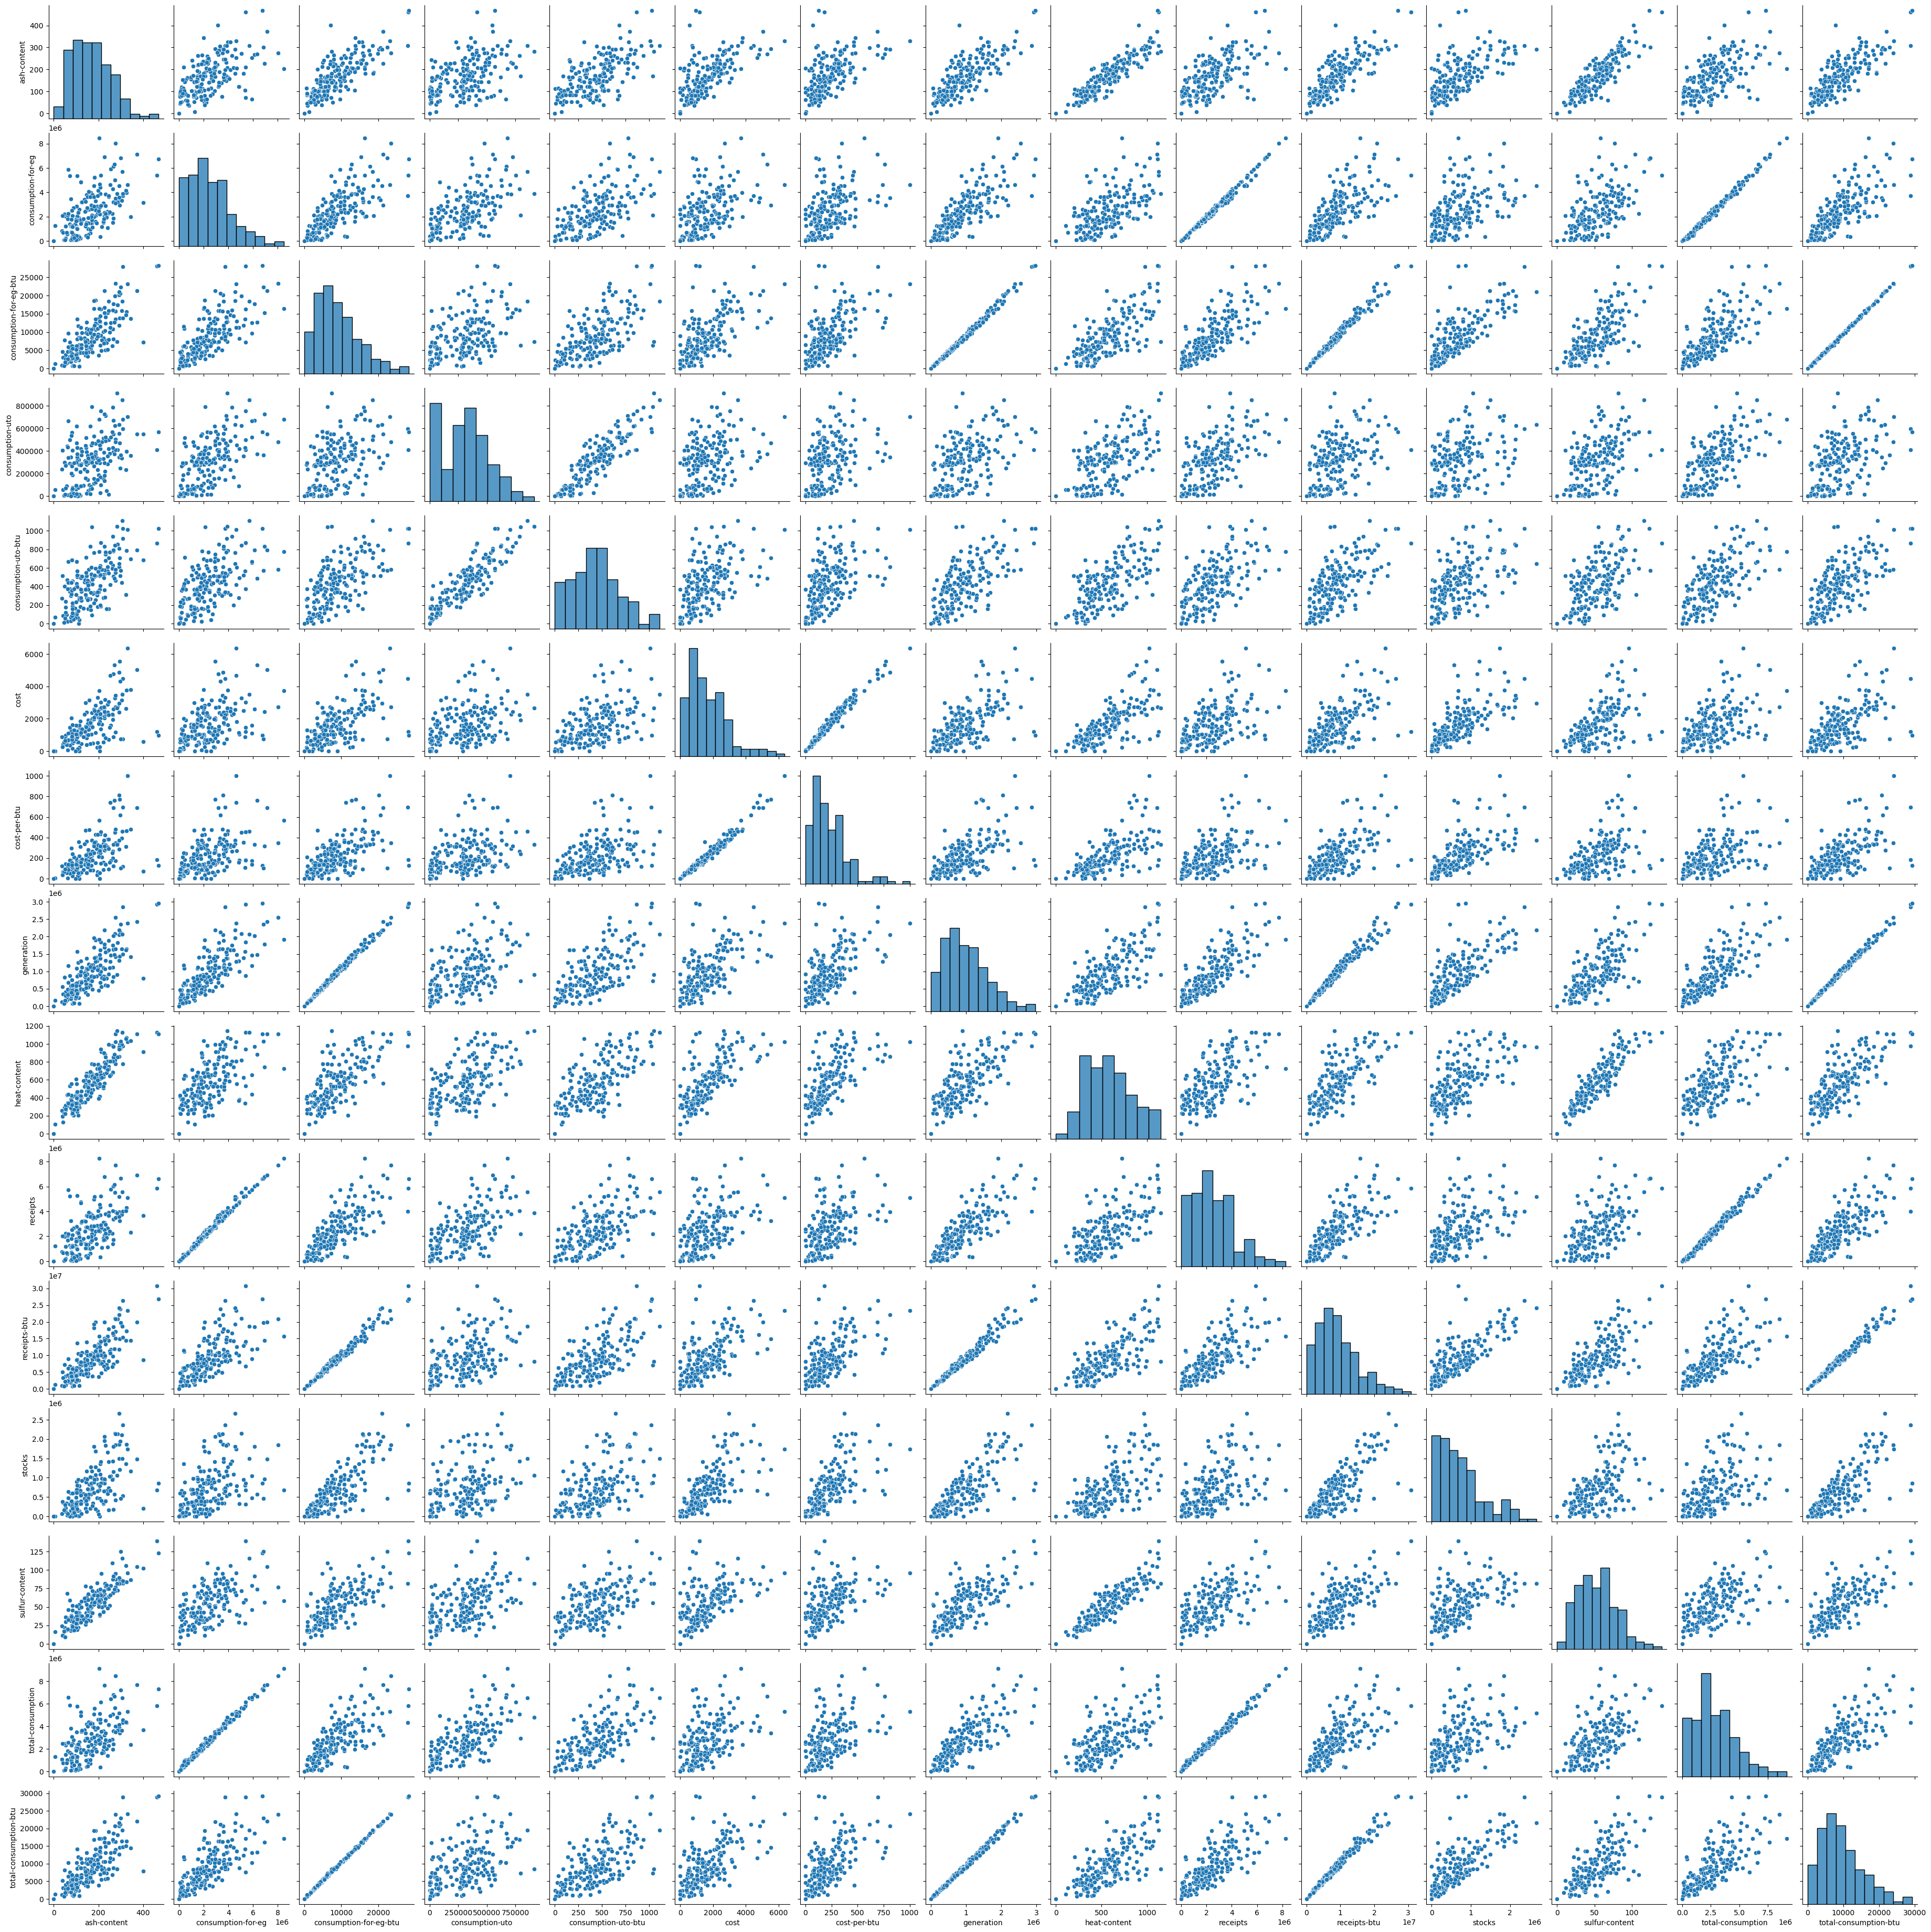

In [50]:
sns.pairplot(ff_df, kind = 'scatter')
plt.show()

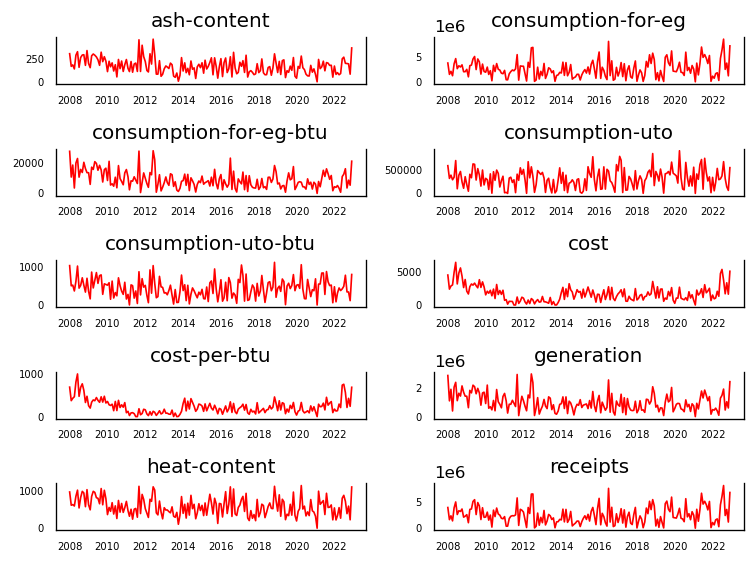

In [51]:
# Plot ff_train_scaled_df's features
plot_feature(ff_df, 5, 2)

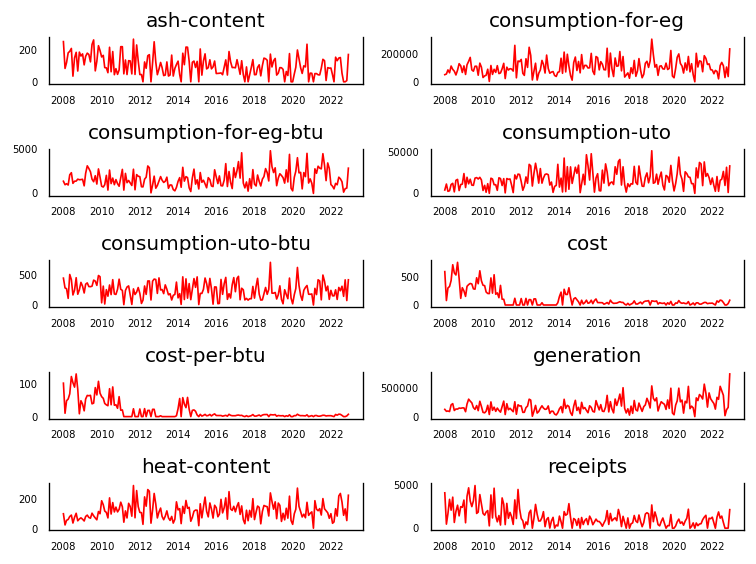

In [52]:
# Plot re_train_scaled_df
plot_feature(re_df, 5, 2)

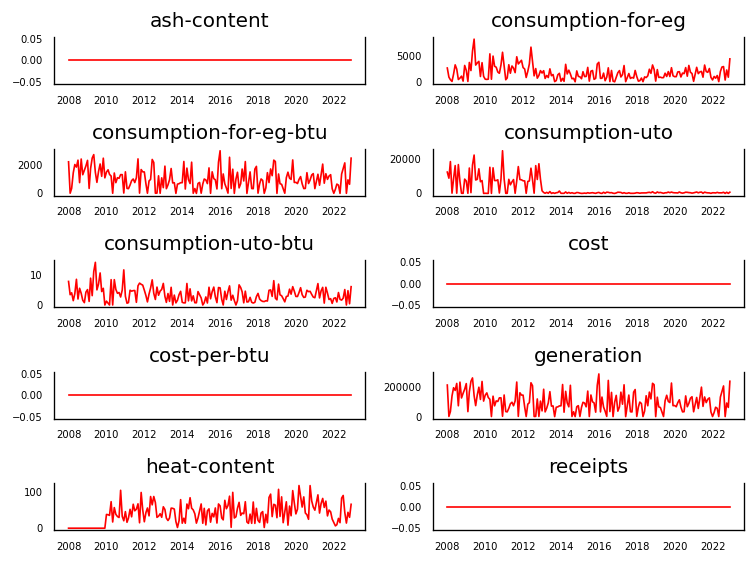

In [53]:
# Plot oth_train_scaled_df's features
plot_feature(oth_df, 5, 2)

### Augmented DIckey-Fuller Test
---
The following features that are best kept so that we may use one model for all energy type are:
* `generation`, `consumption-for-eg`, `consumption-for-eg-btu`, `consumption-uto-btu`, `heat-content`, `total-consumption-btu`

In [54]:
# ADF - Augmented Dickey-Fuller test for ff_train_scaled_df
print_ADF(ff_df.diff()[1:])

real ash-content
ADF Statistic: -7.265039828443857
p-value: 1.643422322329296e-10
----------
real consumption-for-eg
ADF Statistic: -7.614964676443058
p-value: 2.2042296292960305e-11
----------
real consumption-for-eg-btu
ADF Statistic: -7.3205310827597545
p-value: 1.197475584790312e-10
----------
real consumption-uto
ADF Statistic: -7.502441112388783
p-value: 4.218783845691259e-11
----------
real consumption-uto-btu
ADF Statistic: -6.724572660759526
p-value: 3.4153542851407127e-09
----------
real cost
ADF Statistic: -9.460189647490786
p-value: 4.374902120459704e-16
----------
real cost-per-btu
ADF Statistic: -9.164907292893677
p-value: 2.475709548816128e-15
----------
real generation
ADF Statistic: -7.273069132745576
p-value: 1.569923352845479e-10
----------
real heat-content
ADF Statistic: -7.5554011024433185
p-value: 3.109163512112564e-11
----------
real receipts
ADF Statistic: -7.471242073318648
p-value: 5.048245784269795e-11
----------
real receipts-btu
ADF Statistic: -8.243579065

In [55]:
# ADF - Augmented Dickey-Fuller test for re_train_scaled_df
print_ADF(re_df.diff()[1:])

real ash-content
ADF Statistic: -6.29223766696771
p-value: 3.5758631179795516e-08
----------
real consumption-for-eg
ADF Statistic: -7.486601396342969
p-value: 4.621428327377298e-11
----------
real consumption-for-eg-btu
ADF Statistic: -7.045494876612109
p-value: 5.701078924696664e-10
----------
real consumption-uto
ADF Statistic: -7.208701588350554
p-value: 2.2644142142067377e-10
----------
real consumption-uto-btu
ADF Statistic: -6.630869465241879
p-value: 5.719559705377349e-09
----------
real cost
ADF Statistic: -5.466258193657508
p-value: 2.4550295015134764e-06
----------
real cost-per-btu
ADF Statistic: -5.801575832095362
p-value: 4.617824328882837e-07
----------
real generation
ADF Statistic: -7.8001581300679055
p-value: 7.53069127933244e-12
----------
real heat-content
ADF Statistic: -7.0956857099808905
p-value: 4.295464262990447e-10
----------
real receipts
ADF Statistic: -5.775800029695161
p-value: 5.263180685607168e-07
----------
real receipts-btu
ADF Statistic: -7.0679766406

In [56]:
# ADF - Augmented Dickey-Fuller test for oth_train_scaled_df
print_ADF(oth_df.diff()[1:])

ash-content
Failed to run the ADF test
----------
real consumption-for-eg
ADF Statistic: -7.100731254252329
p-value: 4.174763337049771e-10
----------
real consumption-for-eg-btu
ADF Statistic: -6.854917410440398
p-value: 1.6578586046292421e-09
----------
real consumption-uto
ADF Statistic: -7.831196885366543
p-value: 6.28633860415883e-12
----------
real consumption-uto-btu
ADF Statistic: -7.523465881875347
p-value: 3.7376687128958386e-11
----------
cost
Failed to run the ADF test
----------
cost-per-btu
Failed to run the ADF test
----------
real generation
ADF Statistic: -6.8583895361799385
p-value: 1.6261084980517428e-09
----------
real heat-content
ADF Statistic: -4.671105425697361
p-value: 9.532382803572417e-05
----------
receipts
Failed to run the ADF test
----------
receipts-btu
Failed to run the ADF test
----------
stocks
Failed to run the ADF test
----------
sulfur-content
Failed to run the ADF test
----------
real total-consumption
ADF Statistic: -7.854376863614053
p-value: 5.4

In [57]:
ff_data = ff_df[[
    'generation', 'consumption-for-eg-btu'
]]
ff_data.shape

(180, 2)

In [58]:
train_ff_df = ff_data[ : round(ff_data.shape[0] * 0.75)]
test_ff_df = ff_data[round(ff_data.shape[0] * 0.75) : ]

In [59]:
print(train_ff_df.shape, test_ff_df.shape)

(135, 2) (45, 2)


In [60]:
model = VAR(train_ff_df.diff()[1:])

sorted_order =model.select_order(maxlags = 40)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        39.39       39.44   1.275e+17       39.41
1        38.81       38.97   7.168e+16       38.88
2        38.50      38.77*  5.231e+16*      38.61*
3        38.51       38.89   5.326e+16       38.67
4        38.55       39.04   5.550e+16       38.75
5        38.60       39.19   5.811e+16       38.84
6        38.60       39.30   5.805e+16       38.88
7        38.58       39.39   5.716e+16       38.91
8        38.60       39.52   5.848e+16       38.97
9        38.60       39.63   5.892e+16       39.02
10       38.67       39.81   6.342e+16       39.13
11       38.69       39.93   6.464e+16       39.19
12       38.68       40.03   6.466e+16       39.23
13       38.69       40.15   6.562e+16       39.28
14       38.76       40.33   7.071e+16       39.39
15       38.73       40.41   6.975e+16       39.41
16       38.72       40.51   6.

In [61]:
var_model = VARMAX(train_ff_df, order = (40, 0), enforce_stationarity = True)
fitted_model = var_model.fit(maxiter = 100, disp = False)
print(fitted_model.summary())

                                      Statespace Model Results                                      
Dep. Variable:     ['generation', 'consumption-for-eg-btu']   No. Observations:                  135
Model:                                              VAR(40)   Log Likelihood               -2907.132
                                                + intercept   AIC                           6144.265
Date:                                      Sat, 10 Feb 2024   BIC                           6623.635
Time:                                              13:11:36   HQIC                          6339.067
Sample:                                          01-01-2008                                         
                                               - 03-01-2019                                         
Covariance Type:                                        opg                                         
Ljung-Box (L1) (Q):             0.00, 0.03   Jarque-Bera (JB):          11.97, 5.03
Prob(Q)

[Text(0.5, 0, 't'), Text(0.5, 1.0, 'Responses to a shock to dln_inv')]

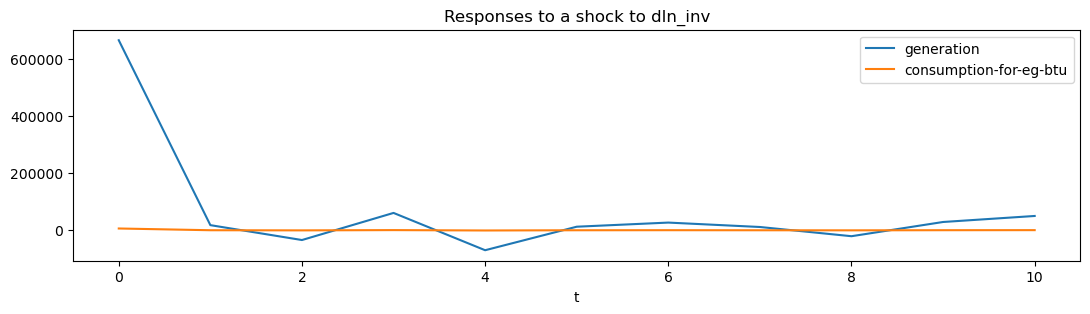

In [62]:
ax = fitted_model.impulse_responses(10, orthogonalized = True).plot(figsize = (13, 3))
ax.set(xlabel = 't', title = 'Responses to a shock to dln_inv')

In [63]:
n_forecast = 45
predict = fitted_model.get_prediction(start = len(train_ff_df), end = len(train_ff_df) + n_forecast - 1)
predictions = predict.predicted_mean

In [64]:
predictions.columns = ['generation_pred', 'consumption-for-eg-btu_pred']
predictions

,generation_pred,consumption-for-eg-btu_pred
2019-04-01,1.106618e+06,10260.971758
2019-05-01,-1.464357e+05,-1892.933142
2019-06-01,1.045868e+06,9581.370909
2019-07-01,1.551995e+05,1444.466171
2019-08-01,7.532573e+05,6345.651014
2019-09-01,-3.624655e+05,-3163.747706
2019-10-01,1.320579e+06,12041.949430
2019-11-01,3.621583e+05,2814.884515
2019-12-01,7.041613e+05,6686.145170
2020-01-01,-1.892069e+05,-2481.165649


In [65]:
test_ff_df

,generation,consumption-for-eg-btu
period,,
2019-04-01,609628.28,5031.90
2019-05-01,591399.61,5236.07
2019-06-01,73319.19,775.53
2019-07-01,997301.71,8230.39
2019-08-01,1562037.38,13605.89
2019-09-01,1021277.69,8977.19
2019-10-01,1122859.31,9749.74
2019-11-01,2024461.61,17767.32
2019-12-01,332743.72,2537.05


In [66]:
test_vs_pred = pd.concat([test_ff_df['generation'], predictions['generation_pred']], axis = 1)

In [67]:
test_vs_pred

,generation,generation_pred
2019-04-01,609628.28,1.106618e+06
2019-05-01,591399.61,-1.464357e+05
2019-06-01,73319.19,1.045868e+06
2019-07-01,997301.71,1.551995e+05
2019-08-01,1562037.38,7.532573e+05
2019-09-01,1021277.69,-3.624655e+05
2019-10-01,1122859.31,1.320579e+06
2019-11-01,2024461.61,3.621583e+05
2019-12-01,332743.72,7.041613e+05
2020-01-01,564779.41,-1.892069e+05


<Axes: >

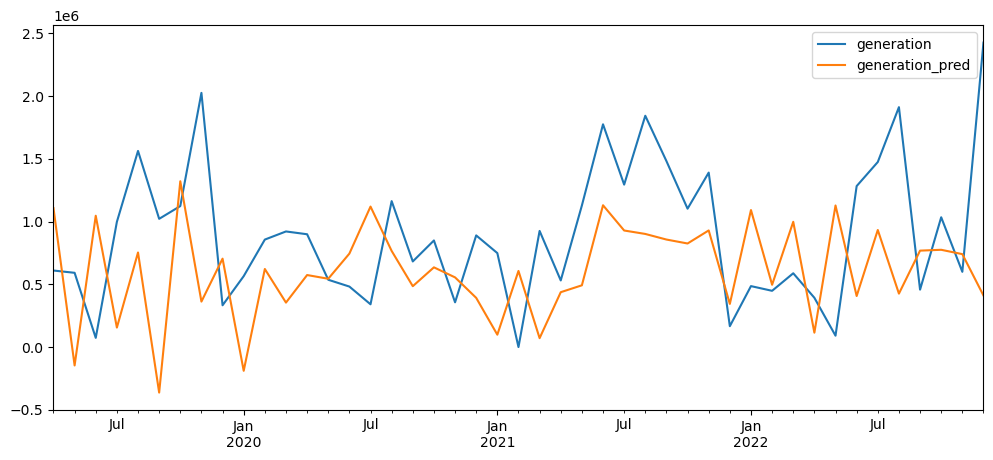

In [68]:
test_vs_pred.plot(figsize = (12, 5))

In [69]:
test_vs_pred = pd.concat([test_ff_df['consumption-for-eg-btu'], predictions['consumption-for-eg-btu_pred']], axis = 1)

In [70]:
test_vs_pred

,consumption-for-eg-btu,consumption-for-eg-btu_pred
2019-04-01,5031.90,10260.971758
2019-05-01,5236.07,-1892.933142
2019-06-01,775.53,9581.370909
2019-07-01,8230.39,1444.466171
2019-08-01,13605.89,6345.651014
2019-09-01,8977.19,-3163.747706
2019-10-01,9749.74,12041.949430
2019-11-01,17767.32,2814.884515
2019-12-01,2537.05,6686.145170
2020-01-01,4684.00,-2481.165649


<Axes: >

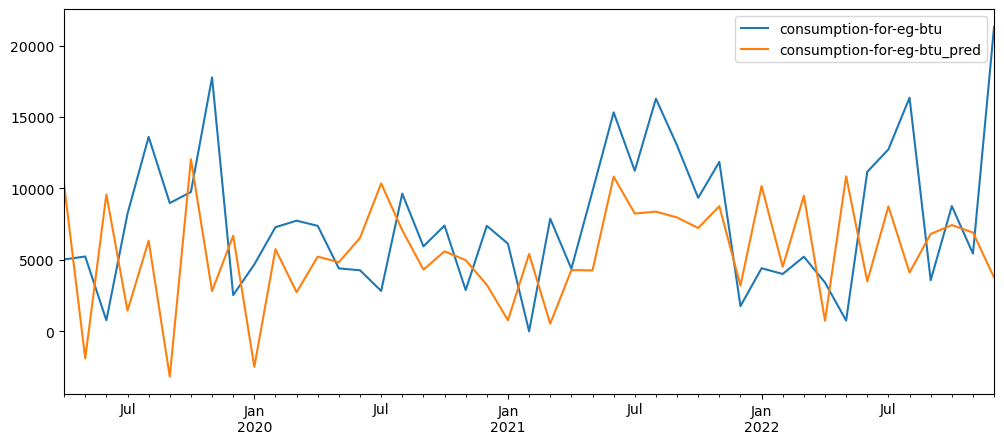

In [71]:
test_vs_pred.plot(figsize = (12, 5))

In [72]:
from sklearn.metrics import mean_squared_error
#mse
#mse = mean_squared_error(y_true, y_pred)
y_true = test_vs_pred['consumption-for-eg-btu'].replace(np.nan, 0)
y_pred = test_vs_pred['consumption-for-eg-btu_pred'].replace(np.nan, 0)
mse = mean_squared_error(y_true, y_pred)

#rmse model
#model_accuracy = nn_model.evaluate(predictions['generation_pred'],predictions['consumption-for-eg-btu_pred'],verbose=2)
print(f" Accuracy: {mse}")

 Accuracy: 40243645.16760785


In [74]:
def forecast_accuracy(forecast, actual):
     #mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) #Mean absolute percentage error
     mae = np.mean(np.abs(forecast - actual))#mean absolute error
     rmse = np.mean((forecast - actual)**2)**.5  # RMSE
     return({ 'mae': mae, 
            'rmse':rmse})
accuracy_test = forecast_accuracy(y_pred,y_true)
print('Forecast Accuracy of: consumption-for-eg-btu')
for k, v in accuracy_test.items(): # k represents the key v represents value
    print(k, ': ', round(v,4))

Forecast Accuracy of: consumption-for-eg-btu
mae :  5081.6413
rmse :  6343.7879


In [83]:
df_forecast_test = test_vs_pred.copy()
df_forecast_test['Absolute Error'] = 0.00
df_forecast_test['Squared Error'] = 0.00
df_forecast_test['Percent Error1'] = 0.00
df_forecast_test['Percent Error2'] = 0.00
df_forecast_test['Percent Error3'] = 0.00
df_forecast_test['Error'] = 0.00
df_forecast_test['Squared Error Diff'] = 0.00

for i in range(len(df_forecast_test)):
    df_forecast_test['Absolute Error'][i] = abs( df_forecast_test['consumption-for-eg-btu_pred'][i] - df_forecast_test['consumption-for-eg-btu'][i] )
    df_forecast_test['Squared Error'][i] = ( df_forecast_test['consumption-for-eg-btu_pred'][i] - df_forecast_test['consumption-for-eg-btu'][i] )**2
    df_forecast_test['Percent Error1'][i] = abs (( df_forecast_test['consumption-for-eg-btu'][i] - df_forecast_test['consumption-for-eg-btu_pred'][i] ) / df_forecast_test['consumption-for-eg-btu'][i])
    df_forecast_test['Percent Error2'][i] = ((df_forecast_test['consumption-for-eg-btu_pred'][i] - df_forecast_test['consumption-for-eg-btu'][i])/ df_forecast_test['consumption-for-eg-btu'][i-1])**2
    df_forecast_test['Percent Error3'][i] = ((df_forecast_test['consumption-for-eg-btu'][i] - df_forecast_test['consumption-for-eg-btu'][i-1] ) / df_forecast_test['consumption-for-eg-btu'][i-1] )**2
    df_forecast_test['Error'][i] = df_forecast_test['Error'][i] = ( df_forecast_test['consumption-for-eg-btu_pred'][i] - df_forecast_test['consumption-for-eg-btu'][i] )
    df_forecast_test['Squared Error Diff'][i] = "{:,.2f}".format((df_forecast_test['Error'][i] - df_forecast_test['Error'][i-1] )**2)
    
df_forecast_test.head()

,consumption-for-eg-btu,consumption-for-eg-btu_pred,Absolute Error,Squared Error,Percent Error1,Percent Error2,Percent Error3,Error,Squared Error Diff
2019-04-01,5031.90,10260.971758,5229.071758,2.734319e+07,1.039184,0.060130,0.583745,5229.071758,"27,343,191.45"
2019-05-01,5236.07,-1892.933142,7129.003142,5.082269e+07,1.361518,2.007214,0.001646,-7129.003142,"152,722,015.22"
2019-06-01,775.53,9581.370909,8805.840909,7.754283e+07,11.354610,2.828335,0.725711,8805.840909,"253,919,254.92"
2019-07-01,8230.39,1444.466171,6785.923829,4.604876e+07,0.824496,76.563320,92.402087,-6785.923829,"243,103,127.64"
2019-08-01,13605.89,6345.651014,7260.238986,5.271107e+07,0.533610,0.778146,0.426576,-7260.238986,"224,974.87"


In [84]:
def mean_squared_error(df_forecast_test):
   mse = np.mean(df_forecast_test['Squared Error'][3:-1])
   return(mse)
   print(mse)

In [86]:
print('Mean Squared Error')
mean_squared_error(df_forecast_test)

Mean Squared Error


32848405.15451995

In [97]:
def root_mean_squared_error(df_forecast_test):
   rsme = np.sqrt(np.mean(df_forecast_test['Squared Error'][3:-1]))
   return(rsme)
   print(rsme)


In [98]:
print('Root Mean Squared Error')
root_mean_squared_error(df_forecast_test)

Root Mean Squared Error


5731.352820627949